Setting up a base folder

In [1]:
!pip install python-dotenv

import glob
import os
import pandas as pd
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

load_dotenv()

drive.mount('/content/drive')

historical_parking_base_folder = '/content/drive/My Drive/NUS-ISS AIS Projects/Project 2/Data/Parking CSV Data/2023'
%cd {base_folder}

numerical_features = ['total_lots', 'available_lots', 'x_coord', 'y_coord']
categorical_features = [
    'car_park_type',
    'type_of_parking_system',
    'short_term_parking',
    'free_parking',
    'night_parking',
    'car_park_basement'
]

Mounted at /content/drive
[Errno 2] No such file or directory: '{base_folder}'
/content


In [2]:
def fetch_data_from_subfolders():
    subfolders = [f.path for f in os.scandir(historical_parking_base_folder) if f.is_dir()]

    # read csv in a dataframe and put all the DataFrames in a list
    dfs = []
    for subfolder in subfolders:
        all_files = glob.glob(os.path.join(subfolder, '*.csv'))
        all_files.sort(key=lambda x: os.path.basename(x))

        for file in all_files:
            df = pd.read_csv(file)
            dfs.append(df)

    # concat all the dataframes
    return pd.concat(dfs, ignore_index=True)

In [3]:
def get_train_test_X_y(resultant_df, target=None, test_size=0.2):
    # prepare X & y (classification)
    X, y_encoded = get_X_y_encoded(resultant_df, target)

    # train and test split for X & y
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded)

    print("Shape of X_train = ", X_train.shape)
    print("Shape of X_test = ", X_test.shape)
    print("Shape of y_train = ", y_train.shape)
    print("Shape of y_test = ", y_test.shape)

    return X_train, X_test, y_train, y_test

In [4]:
def get_X_y_encoded(resultant_df, target=None):
    if target is None:
        target = ['car_park_number']

    X = resultant_df.drop(columns=target).to_numpy()
    y = resultant_df[target]

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    return X, y_encoded

Preparing Data

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import os

load_dotenv()

def prepare_historical_parking_df_v2():
    historical_parking_df = fetch_data_from_subfolders()

    # feature engineering - updated timestamp
    historical_parking_df['update_timestamp'] = pd.to_datetime(historical_parking_df['update_timestamp'])

    # get month, day_of_week, hour
    historical_parking_df['month'] = historical_parking_df['update_timestamp'].dt.month
    historical_parking_df['day_of_week'] = historical_parking_df['update_timestamp'].dt.weekday
    historical_parking_df['hour'] = historical_parking_df['update_timestamp'].dt.hour

    # create cyclic features from month, day_of_week, hour
    historical_parking_df['sin_hour'] = np.sin(2 * np.pi * historical_parking_df['hour'] / 24)
    historical_parking_df['cos_hour'] = np.cos(2 * np.pi * historical_parking_df['hour'] / 24)

    historical_parking_df['sin_day_of_week'] = np.sin(2 * np.pi * historical_parking_df['day_of_week'] / 7)
    historical_parking_df['cos_day_of_week'] = np.cos(2 * np.pi * historical_parking_df['day_of_week'] / 7)

    historical_parking_df['sin_month'] = np.sin(2 * np.pi * historical_parking_df['month'] / 12)
    historical_parking_df['cos_month'] = np.cos(2 * np.pi * historical_parking_df['month'] / 12)

    # drop not required features
    historical_parking_df = historical_parking_df.drop(
        columns=['fetch_timestamp', 'lot_type', 'update_timestamp', 'month', 'day_of_week', 'hour']
    )

    print("Historical parking data shape = ", historical_parking_df.shape)
    print("Historical parking data top 5")
    print(historical_parking_df.head())

    historical_parking_df = historical_parking_df[:100000]

    return historical_parking_df

In [6]:
def prepare_parking_info_df_v2(folder_path = None):
    parking_info_df = pd.read_csv('/content/drive/My Drive/NUS-ISS AIS Projects/Project 2/Data/HDBCarparkInformation.csv')

    parking_info_df = (parking_info_df
           .drop(columns=['address', 'gantry_height'])
           .rename(columns={'car_park_no': 'car_park_number'}))

    encoder = OneHotEncoder()
    encoded_features = pd.DataFrame(encoder.fit_transform(parking_info_df[categorical_features]).toarray(),
            columns=encoder.get_feature_names_out())
    parking_info_df = parking_info_df.drop(columns=categorical_features).reset_index(drop=True)

    print("Car park static info shape = ", parking_info_df.shape)
    print("Car park static info top 5")
    print(parking_info_df.head())

    parking_info_df = parking_info_df[:100000]

    return pd.concat([parking_info_df, encoded_features], axis=1)

In [7]:
def prepare_resultant_df_v2():
    # fetch prepared car lot info (static)
    parking_info_df = prepare_parking_info_df_v2()

    # fetch prepared car parking data (historical)
    historical_parking_df = prepare_historical_parking_df_v2()

    # prepare a resultant DataFrame
    resultant_df = pd.merge(historical_parking_df, parking_info_df, on='car_park_number', how='inner')

    #resultant_data = resultant_data[:100000]

    scaler = MinMaxScaler()
    resultant_df[numerical_features] = scaler.fit_transform(resultant_df[numerical_features])

    print("Resultant dataframe shape = ", resultant_df.shape)
    print("Resultant dataframe top 5")
    print(resultant_df.head())

    return resultant_df

In [8]:
if __name__ == '__main__':
    print(prepare_resultant_df_v2())

Car park static info shape =  (2243, 4)
Car park static info top 5
  car_park_number     x_coord     y_coord  car_park_decks
0             ACB  30314.7936  31490.4942               1
1             ACM  33758.4143  33695.5198               5
2             AH1  29257.7203  34500.3599               0
3            AK19  28185.4359  39012.6664               0
4            AK31  29482.0290  38684.1754               0
Historical parking data shape =  (114693019, 9)
Historical parking data top 5
  car_park_number  total_lots  available_lots  sin_hour  cos_hour  \
0            HE12         105              44 -0.258819  0.965926   
1             HLM         583             485 -0.258819  0.965926   
2             RHM         329             123 -0.258819  0.965926   
3            BM29          97              85 -0.258819  0.965926   
4             Q81          96              78 -0.258819  0.965926   

   sin_day_of_week  cos_day_of_week  sin_month  cos_month  
0         0.781831          0.62

Pre-Processing Data

In [11]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#from xgboost import XGBClassifier
# from yellowbrick.cluster import KElbowVisualizer
import glob
import os

In [13]:
parking_base_folder = historical_parking_base_folder

subfolders = [f.path for f in os.scandir(parking_base_folder) if f.is_dir()]

In [14]:
dfs = []
for subfolder in subfolders:
    all_files = glob.glob(os.path.join(subfolder, '*.csv'))
    all_files.sort(key=lambda x: os.path.basename(x))

    for file in all_files:
        df = pd.read_csv(file)
        dfs.append(df)

In [15]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:           334Gi       9.1Gi       291Gi       3.0Mi        34Gi       323Gi
Swap:             0B          0B          0B


In [16]:
parking_final_df = pd.concat(dfs, ignore_index=True)

In [17]:
parking_final_df['occupied_lots'] = parking_final_df['total_lots'] - parking_final_df['available_lots']

In [18]:
parking_final_df.shape

(114693019, 7)

In [19]:
parking_final_df.head()

,fetch_timestamp,car_park_number,total_lots,available_lots,lot_type,update_timestamp,occupied_lots
0,2023-02-01T00:00:27,HE12,105,44,C,2023-01-31T23:59:28,61
1,2023-02-01T00:00:27,HLM,583,485,C,2023-01-31T23:59:24,98
2,2023-02-01T00:00:27,RHM,329,123,C,2023-01-31T23:59:28,206
3,2023-02-01T00:00:27,BM29,97,85,C,2023-01-31T23:59:01,12
4,2023-02-01T00:00:27,Q81,96,78,C,2023-01-31T23:59:14,18


In [20]:
parking_info_df = pd.read_csv('/content/drive/My Drive/NUS-ISS AIS Projects/Project 2/Data/HDBCarparkInformation.csv')

parking_info_df['car_park_type'] = pd.Categorical(parking_info_df['car_park_type']).codes
parking_info_df['type_of_parking_system'] = pd.Categorical(parking_info_df['type_of_parking_system']).codes
parking_info_df['short_term_parking'] = pd.Categorical(parking_info_df['short_term_parking']).codes
parking_info_df['free_parking'] = pd.Categorical(parking_info_df['free_parking']).codes
parking_info_df['night_parking'] = pd.Categorical(parking_info_df['night_parking']).codes
parking_info_df['car_park_decks'] = pd.Categorical(parking_info_df['car_park_decks']).codes
parking_info_df['car_park_basement'] = pd.Categorical(parking_info_df['car_park_basement']).codes

parking_info_df.drop(labels=['gantry_height'], axis=1, inplace=True)
parking_info_df.rename(columns={'car_park_no': 'car_park_number'}, inplace=True)

In [21]:
parking_info_df.head()

,car_park_number,address,x_coord,y_coord,car_park_type,type_of_parking_system,short_term_parking,free_parking,night_parking,car_park_decks,car_park_basement
0,ACB,BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK,30314.7936,31490.4942,0,1,3,0,1,1,1
1,ACM,BLK 98A ALJUNIED CRESCENT,33758.4143,33695.5198,4,1,3,2,1,5,0
2,AH1,BLK 101 JALAN DUSUN,29257.7203,34500.3599,5,1,3,2,1,0,0
3,AK19,BLOCK 253 ANG MO KIO STREET 21,28185.4359,39012.6664,5,0,1,0,0,0,0
4,AK31,BLK 302/348 ANG MO KIO STREET 31,29482.0290,38684.1754,5,0,2,0,0,0,0


In [22]:
# merge the 2 results and then drop the columns that are not needed

resultant_df = pd.merge(parking_final_df, parking_info_df, on='car_park_number', how='inner')
resultant_df.drop(['fetch_timestamp', 'lot_type', 'address'], axis=1, inplace=True)
resultant_df.head()

,car_park_number,total_lots,available_lots,update_timestamp,occupied_lots,x_coord,y_coord,car_park_type,type_of_parking_system,short_term_parking,free_parking,night_parking,car_park_decks,car_park_basement
0,HE12,105,44,2023-01-31T23:59:28,61,26367.5806,30069.2434,5,1,3,2,1,0,0
1,HLM,583,485,2023-01-31T23:59:24,98,29354.6692,29687.5080,4,1,3,0,1,11,0
2,RHM,329,123,2023-01-31T23:59:28,206,26359.4531,29876.1692,4,1,3,2,1,10,0
3,BM29,97,85,2023-01-31T23:59:01,12,26194.9184,29563.3295,0,1,3,0,1,1,1
4,Q81,96,78,2023-01-31T23:59:14,18,23531.2041,32206.3235,5,1,3,0,1,0,0


In [23]:
resultant_df['update_timestamp'] = pd.to_datetime(resultant_df['update_timestamp'])

resultant_df['update_year'] = resultant_df['update_timestamp'].dt.year
resultant_df['update_month'] = resultant_df['update_timestamp'].dt.month
resultant_df['update_day'] = resultant_df['update_timestamp'].dt.day
resultant_df['update_hour'] = resultant_df['update_timestamp'].dt.hour
resultant_df['update_minute'] = resultant_df['update_timestamp'].dt.minute
resultant_df['update_second'] = resultant_df['update_timestamp'].dt.second
resultant_df.drop('update_timestamp', axis=1, inplace=True)

resultant_df.head()

,car_park_number,total_lots,available_lots,occupied_lots,x_coord,y_coord,car_park_type,type_of_parking_system,short_term_parking,free_parking,night_parking,car_park_decks,car_park_basement,update_year,update_month,update_day,update_hour,update_minute,update_second
0,HE12,105,44,61,26367.5806,30069.2434,5,1,3,2,1,0,0,2023,1,31,23,59,28
1,HLM,583,485,98,29354.6692,29687.5080,4,1,3,0,1,11,0,2023,1,31,23,59,24
2,RHM,329,123,206,26359.4531,29876.1692,4,1,3,2,1,10,0,2023,1,31,23,59,28
3,BM29,97,85,12,26194.9184,29563.3295,0,1,3,0,1,1,1,2023,1,31,23,59,1
4,Q81,96,78,18,23531.2041,32206.3235,5,1,3,0,1,0,0,2023,1,31,23,59,14


In [24]:
resultant_df_small = resultant_df[:10000]
X = resultant_df_small.drop('car_park_number', axis=1)
y = resultant_df_small['car_park_number']

In [25]:
X.head()

,total_lots,available_lots,occupied_lots,x_coord,y_coord,car_park_type,type_of_parking_system,short_term_parking,free_parking,night_parking,car_park_decks,car_park_basement,update_year,update_month,update_day,update_hour,update_minute,update_second
0,105,44,61,26367.5806,30069.2434,5,1,3,2,1,0,0,2023,1,31,23,59,28
1,583,485,98,29354.6692,29687.5080,4,1,3,0,1,11,0,2023,1,31,23,59,24
2,329,123,206,26359.4531,29876.1692,4,1,3,2,1,10,0,2023,1,31,23,59,28
3,97,85,12,26194.9184,29563.3295,0,1,3,0,1,1,1,2023,1,31,23,59,1
4,96,78,18,23531.2041,32206.3235,5,1,3,0,1,0,0,2023,1,31,23,59,14


In [26]:
y_encoded = LabelEncoder().fit_transform(y)

In [27]:
np.unique(y_encoded).shape

(1911,)

In [28]:
# mutual info of each feature with classification output
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

,MI Scores
x_coord,8.084116
y_coord,8.070499
total_lots,7.089838
occupied_lots,4.747307
available_lots,4.436082
car_park_type,4.402418
update_year,4.024953
short_term_parking,3.863233
type_of_parking_system,3.853910
night_parking,3.658991


In [29]:
# correlation of features with each other
X.corr()

,total_lots,available_lots,occupied_lots,x_coord,y_coord,car_park_type,type_of_parking_system,short_term_parking,free_parking,night_parking,car_park_decks,car_park_basement,update_year,update_month,update_day,update_hour,update_minute,update_second
total_lots,1.000000,0.867024,0.804057,-0.069618,0.311286,-0.180785,-0.023831,0.201319,0.246138,0.233100,0.320977,-0.018169,-0.048058,0.084970,-0.084869,-0.085829,-0.061417,0.065424
available_lots,0.867024,1.000000,0.400890,-0.078261,0.215113,-0.210472,-0.008749,0.229542,0.180340,0.235689,0.373996,-0.000889,-0.090907,0.092505,-0.046908,-0.043900,-0.028743,0.042825
occupied_lots,0.804057,0.400890,1.000000,-0.034618,0.315657,-0.081252,-0.033376,0.096252,0.237367,0.147350,0.143890,-0.032345,0.020113,0.045846,-0.100070,-0.105424,-0.078626,0.069189
x_coord,-0.069618,-0.078261,-0.034618,1.000000,0.034360,-0.046099,-0.037466,-0.079281,-0.095196,-0.069198,-0.029853,0.047862,-0.008181,-0.018978,0.050341,0.050883,0.039440,0.058256
y_coord,0.311286,0.215113,0.315657,0.034360,1.000000,-0.161384,-0.048852,0.094826,0.079124,0.092010,0.238420,0.019988,-0.033509,0.071710,-0.126599,-0.129234,-0.082412,0.122208
car_park_type,-0.180785,-0.210472,-0.081252,-0.046099,-0.161384,1.000000,-0.018530,-0.094045,0.036732,-0.120034,-0.461440,-0.708104,0.007828,-0.009893,0.026848,0.039268,0.032662,0.020145
type_of_parking_system,-0.023831,-0.008749,-0.033376,-0.037466,-0.048852,-0.018530,1.000000,0.045538,0.029848,0.063515,0.027938,0.008386,0.136886,-0.083300,0.000536,0.001337,-0.011401,-0.043592
short_term_parking,0.201319,0.229542,0.096252,-0.079281,0.094826,-0.094045,0.045538,1.000000,0.315909,0.940638,0.291364,-0.075164,-0.011947,0.026924,-0.015721,-0.020354,-0.019239,-0.004579
free_parking,0.246138,0.180340,0.237367,-0.095196,0.079124,0.036732,0.029848,0.315909,1.000000,0.388485,0.228212,-0.177247,-0.032604,0.032704,-0.015316,-0.013255,-0.013639,0.000301
night_parking,0.233100,0.235689,0.147350,-0.069198,0.092010,-0.120034,0.063515,0.940638,0.388485,1.000000,0.311144,-0.066815,-0.000490,0.026509,-0.022067,-0.026177,-0.029000,-0.002606


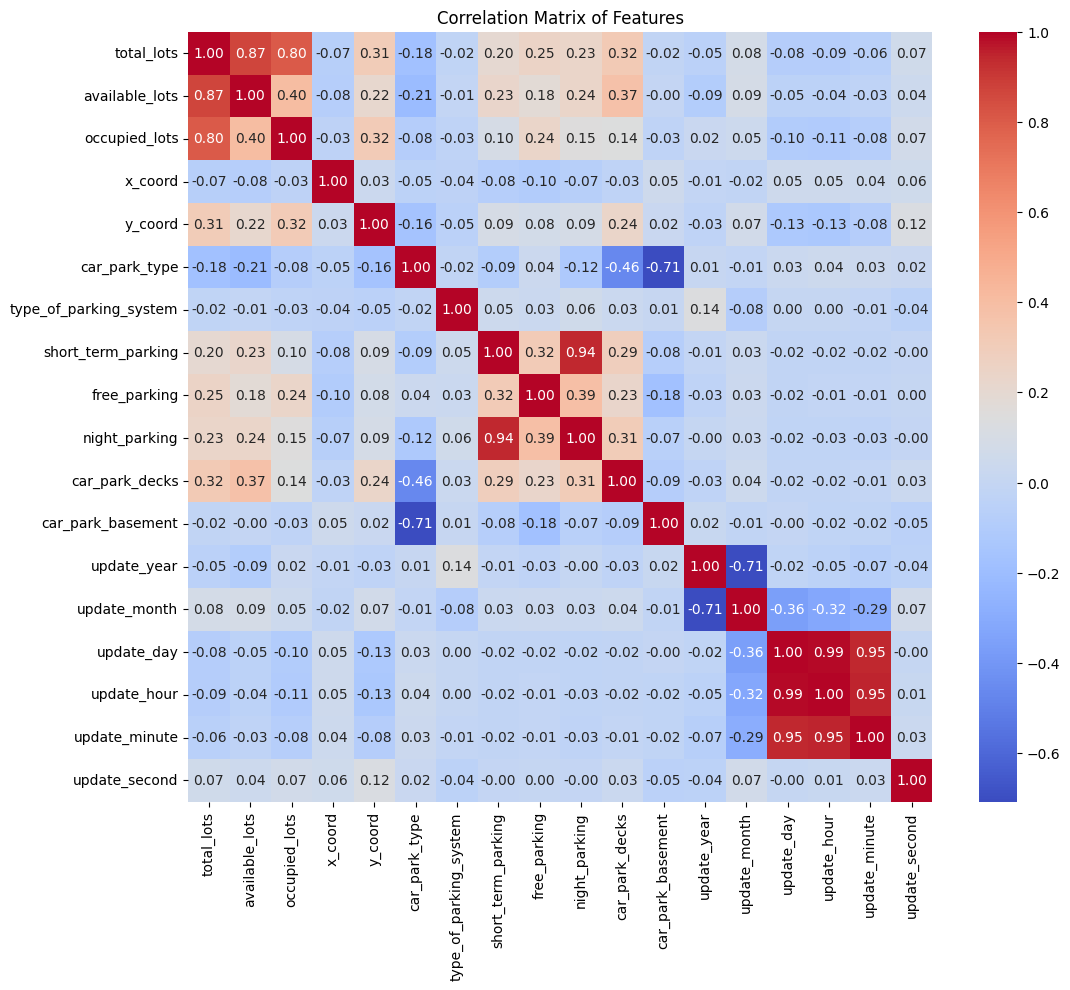

In [30]:
#Visualization of correlation
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = X.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

DBSCAN Algorithm for Clustering

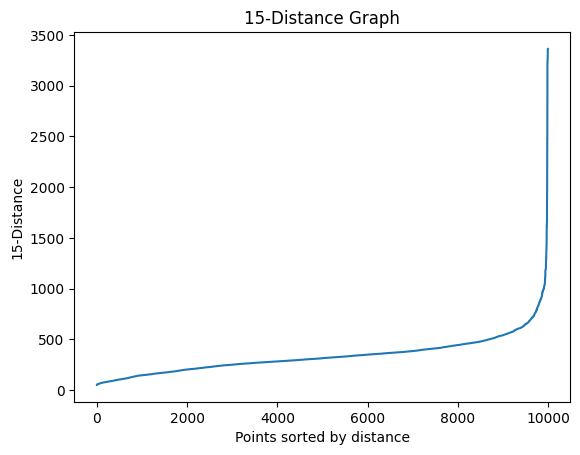

In [61]:
#Creating k-distance plot and choosing parameters eps and minPts

from sklearn.neighbors import NearestNeighbors

# Set k to be the minimum points
k = 15

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort the distances (plot the k-distance graph)
distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-Distance")
plt.title(f"{k}-Distance Graph")
plt.show()

In [62]:
#Implementing DBSCAN

from sklearn.cluster import DBSCAN

# Assuming scaled_data is your preprocessed dataset
dbscan = DBSCAN(eps=10000, min_samples=k)
dbscan.fit(X)

# Get cluster labels (Note: -1 represents noise points)
labels = dbscan.labels_

# Check the number of clusters and noise points
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

Estimated number of clusters: 1
Estimated number of noise points: 0


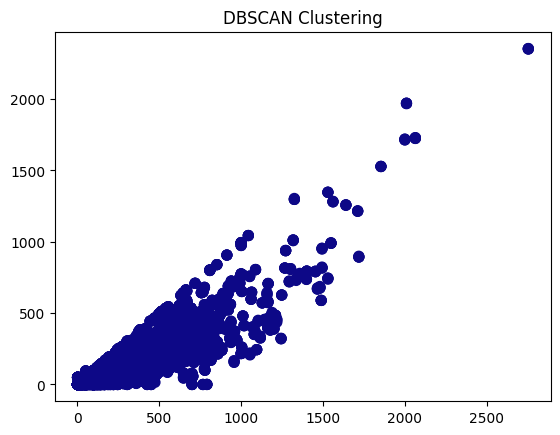

In [63]:
#Visualizing the clusters in 2D

import matplotlib.pyplot as plt

plt.scatter(X['total_lots'], X['available_lots'], c=labels, cmap='plasma', s=50)
plt.title("DBSCAN Clustering")
plt.show()


In [64]:
#Evaluating using Silouette Score

from sklearn.metrics import silhouette_score

score = silhouette_score(X, y_encoded)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.7077802480650497



For k= 1 



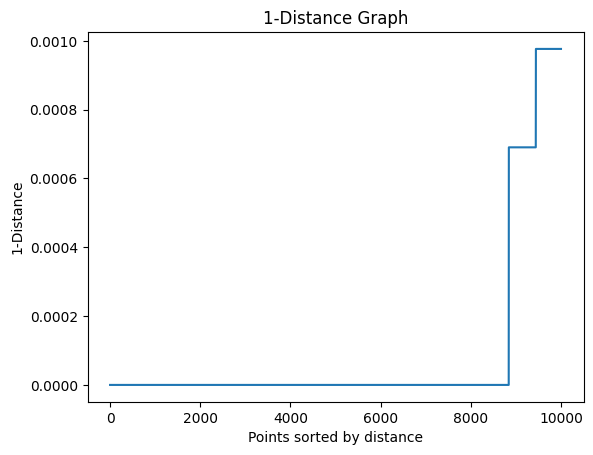

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 2 



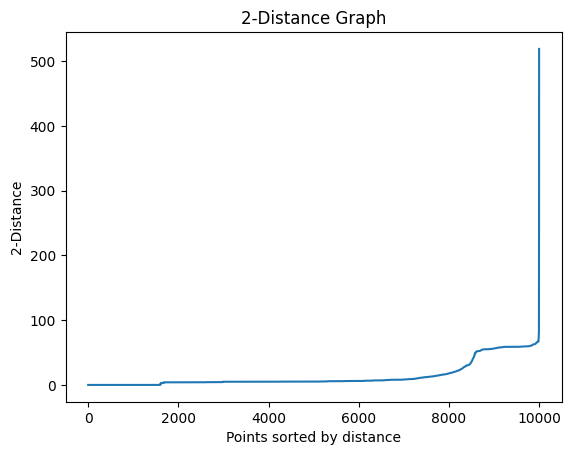

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 3 



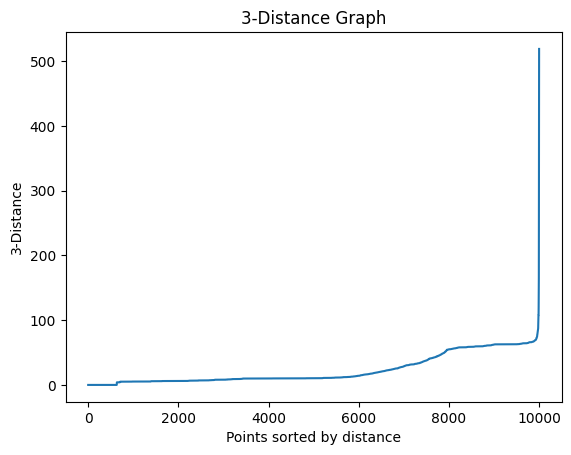

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 4 



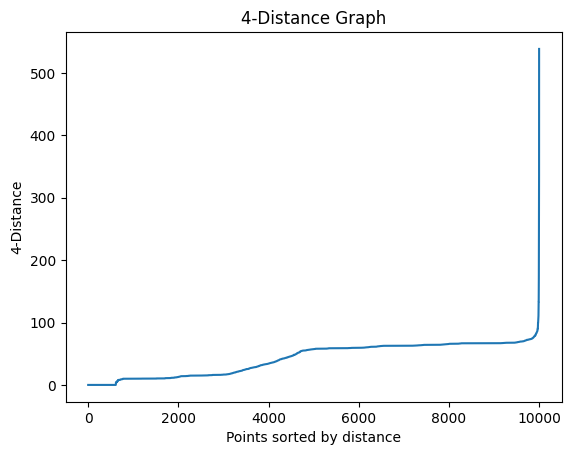

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 5 



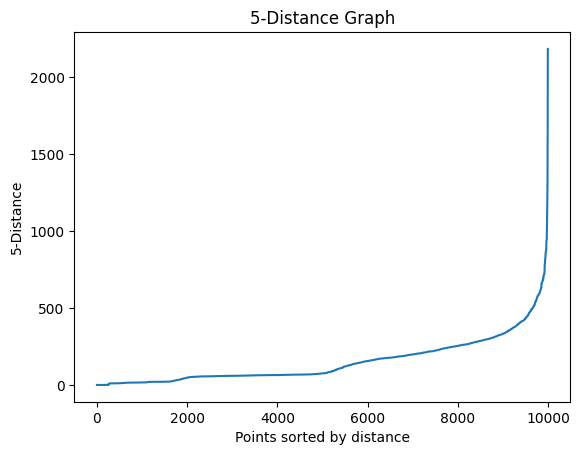

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 6 



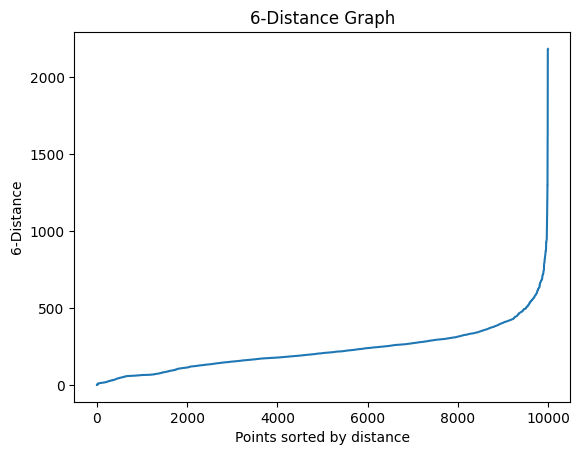

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 7 



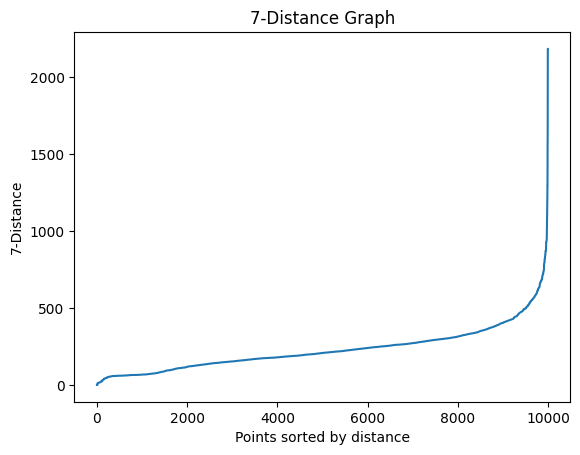

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 8 



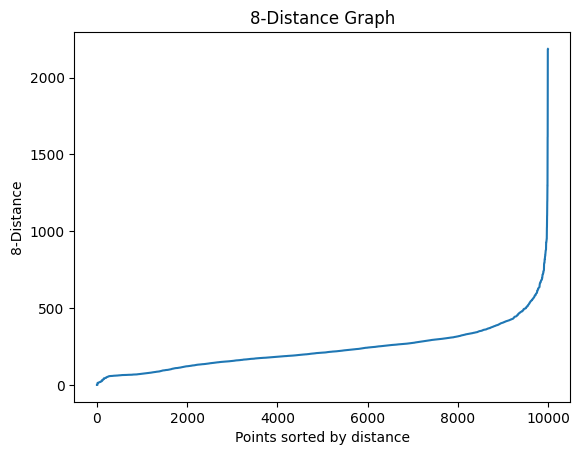

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 9 



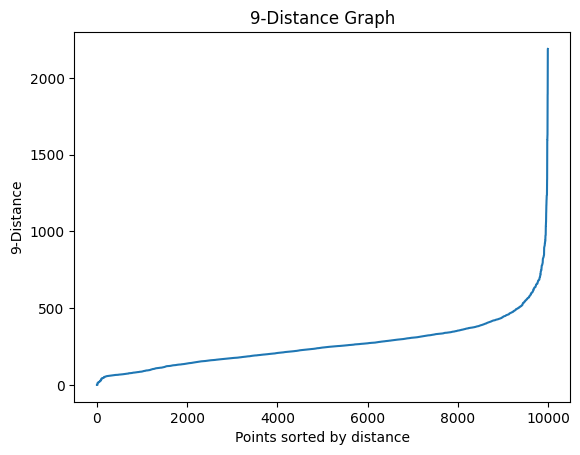

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 10 



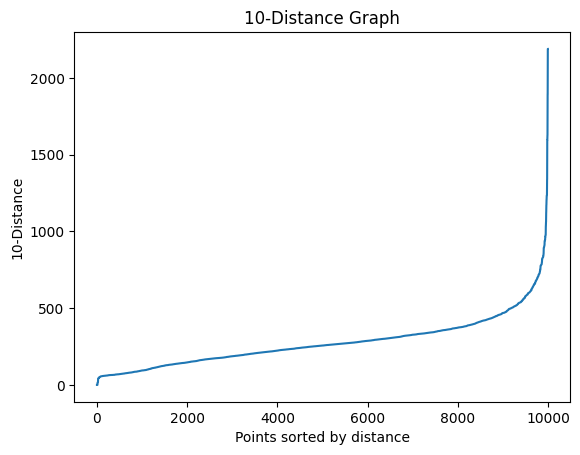

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 11 



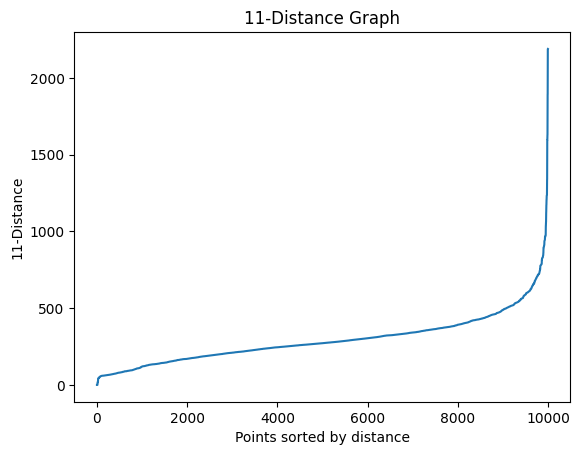

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 12 



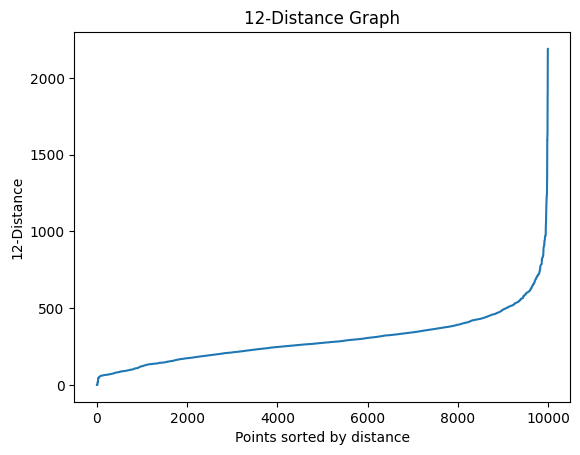

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 13 



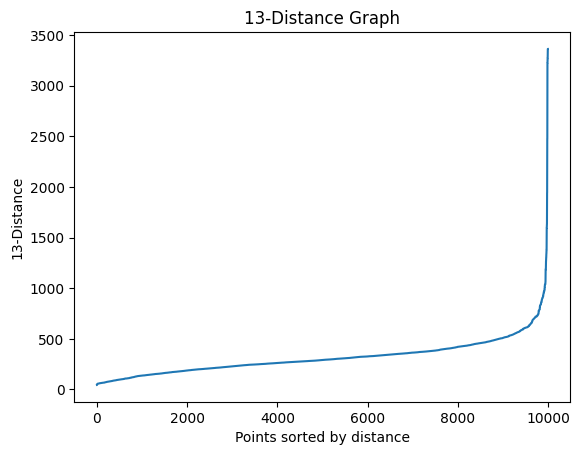

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 14 



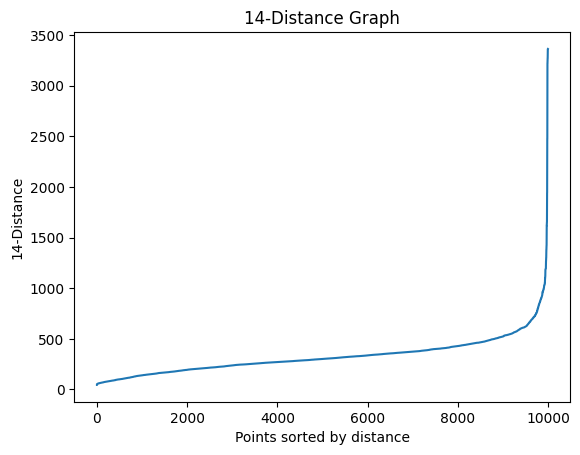

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 15 



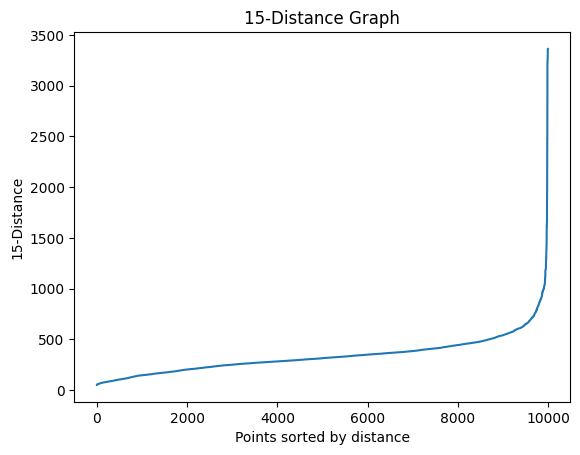

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 16 



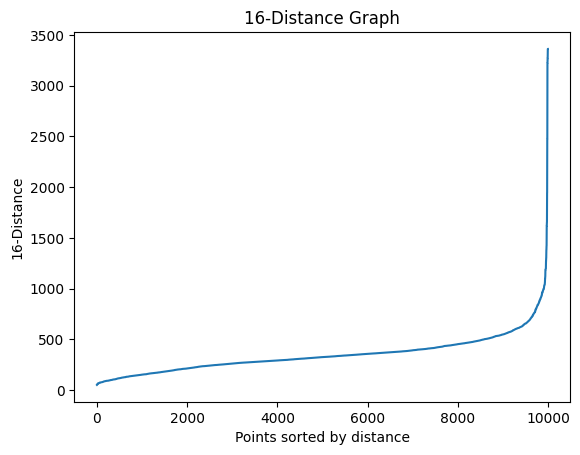

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 17 



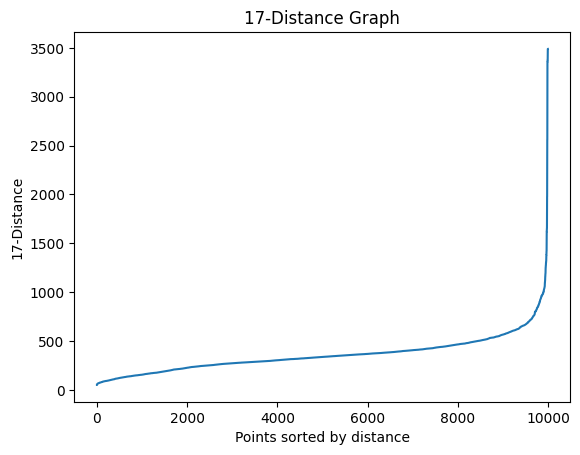

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 18 



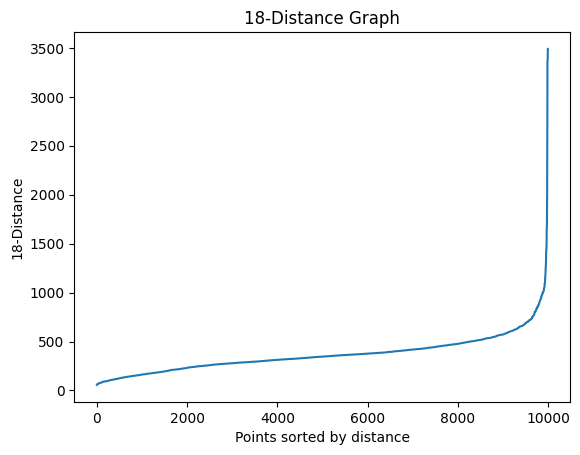

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 19 



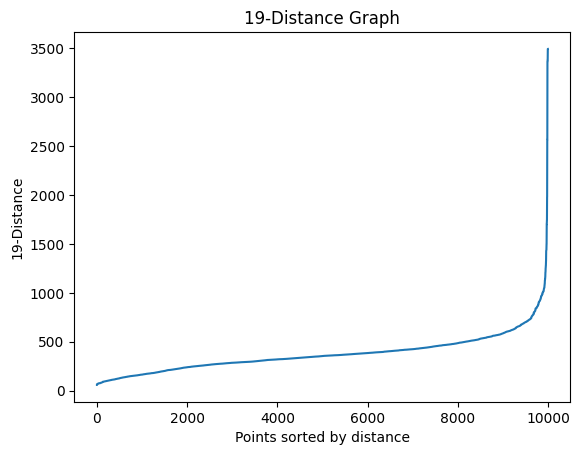

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497

For k= 20 



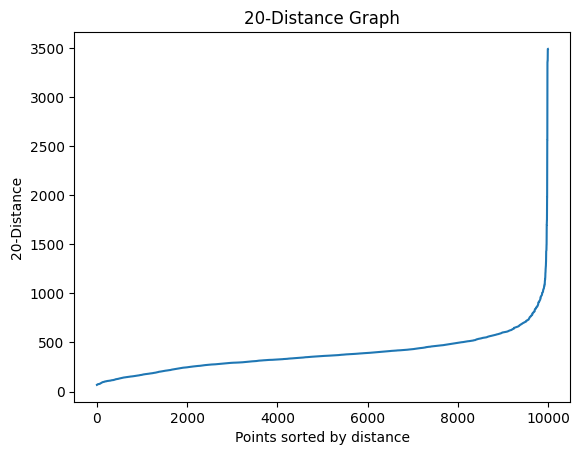

Estimated number of clusters: 1
Estimated number of noise points: 0
Silhouette Score: 0.7077802480650497


In [67]:
#Trying with different values of K

for k in range(1, 21):
  print('\nFor k=', k,'\n')

  neighbors = NearestNeighbors(n_neighbors=k)
  neighbors_fit = neighbors.fit(X)
  distances, indices = neighbors_fit.kneighbors(X)

  distances = np.sort(distances[:, k-1], axis=0)
  plt.plot(distances)
  plt.xlabel("Points sorted by distance")
  plt.ylabel(f"{k}-Distance")
  plt.title(f"{k}-Distance Graph")
  plt.show()

  dbscan = DBSCAN(eps=9800, min_samples=k)
  dbscan.fit(X)

  labels = dbscan.labels_

  n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise = list(labels).count(-1)

  print(f"Estimated number of clusters: {n_clusters}")
  print(f"Estimated number of noise points: {n_noise}")

  score = silhouette_score(X, y_encoded)
  print(f"Silhouette Score: {score}")


